In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
from wf_basis import Sr1s, Sr2s, Sr3s, Sr2p, Sk1s, Sk2s, Sk3s, Sk2p
import periodictable
from IPython.display import display

# Electron configurations dictionary for Z=2 to 10 helpful for later (need to know the number of e)
ELEC_CONFIG = {
    2: [2, 0, 0],   # He 1s2
    3: [2, 1, 0],   # Li 1s2 2s1
    4: [2, 2, 0],   # Be 1s2 2s2
    5: [2, 2, 1],   # B  1s2 2s2 2p1
    6: [2, 2, 2],   # C  1s2 2s2 2p2
    7: [2, 2, 3],   # N  1s2 2s2 2p3
    8: [2, 2, 4],   # O  1s2 2s2 2p4
    9: [2, 2, 5],   # F  1s2 2s2 2p5
    10: [2, 2, 6]   # Ne 1s2 2s2 2p6
}

def build_orbital_func(sub_df, space='r'):               #nested function returns orbital_func(x) function and not a certain value
    def orbital_func(x):                                 #which calculates the combined orbital value at coordinate x.
        total = 0.0                                      #it takes subset of data df ,describing the orbital contributions, loops over rows
        for _, row in sub_df.iterrows():                 # depending the space we working (default is r) uses wavefunctions (Sr or Sk)  
            z, c, s = row['zeff'], row['coeff'], row['sto']               # multiplying each by its coefficients and summing.
            if space == 'r':  
                if s == "1s": total += c * Sr1s(z, x)
                elif s == "2s": total += c * Sr2s(z, x)
                elif s == "3s": total += c * Sr3s(z, x)
                elif s == "2p": total += c * Sr2p(z, x)
            else:  
                if s == "1s": total += c * Sk1s(z, x)
                elif s == "2s": total += c * Sk2s(z, x)
                elif s == "3s": total += c * Sk3s(z, x)
                elif s == "2p": total += c * Sk2p(z, x)
        return total
    return orbital_func

def calculate_quantities(data, Z):     #function that calculates all the informative quantities we need, inputs:data and Z
    df = data[data['Z'] == Z]          #to Filter the data and selecting only data for the desired element.
    el_struct = ELEC_CONFIG[Z]
    total_e = sum(el_struct)           #sum of electrons for each data (need it later)

    func_r1s = build_orbital_func(df[df['orb'] == 'r1s'], 'r') 
    func_r2s = build_orbital_func(df[df['orb'] == 'r2s'], 'r')
    func_r2p = build_orbital_func(df[df['orb'] == 'r2p'], 'r') if 'r2p' in df['orb'].unique() else lambda x: 0.0

    func_k1s = build_orbital_func(df[df['orb'] == 'r1s'], 'k')
    func_k2s = build_orbital_func(df[df['orb'] == 'r2s'], 'k')
    func_k2p = build_orbital_func(df[df['orb'] == 'r2p'], 'k') if 'r2p' in df['orb'].unique() else lambda x: 0.0

    #All these func_ using the function build_orbital_func and making callable functions for wavefunctions of each orbital (r1s, r2s, r2p)
    # and in both spaces .If r2p does not exist in data we use a zero function (lambda x: 0.0).



    
    # Density functions in both spaces 
    def Pr(x):
        return (el_struct[0] * func_r1s(x)**2 + 
                el_struct[1] * func_r2s(x)**2 + 
                el_struct[2] * func_r2p(x)**2) / (4 * np.pi * total_e)

    def Nk(x):
        return (el_struct[0] * func_k1s(x)**2 + 
                el_struct[1] * func_k2s(x)**2 + 
                el_struct[2] * func_k2p(x)**2) / (4 * np.pi * total_e)

    # General Shannon entropy function in which we will call later to calculate Sr and Sk
    def entropy(f):
        eps = 1e-12  # really small epsilon value because when the value inside ln is close to 0 it shows error
        return -4 * np.pi * quad(lambda x: f(x) * np.log(f(x) + eps) * x**2, 0, 1000)[0]   #we calculated until 1000 because we faced error in infinity 

    # Maximum entropy in both spaces 
    def smax(pr, nk):
        r2 = 4 * np.pi * quad(lambda r: pr(r) * r**4, 0, np.inf)[0]
        k2 = 4 * np.pi * quad(lambda k: nk(k) * k**4, 0, np.inf)[0]
        return 3 * (1 + np.log(np.pi)) + 1.5 * np.log(4/9 * r2 * k2)

    # Onicescu value
    def onicescu(pr, nk):
        er = 4 * np.pi * quad(lambda r: pr(r)**2 * r**2, 0, np.inf)[0]
        ek = 4 * np.pi * quad(lambda k: nk(k)**2 * k**2, 0, np.inf)[0]
        return 1 / (er * ek)

   
    Sr = entropy(Pr)
    Sk = entropy(Nk)
    S = Sr + Sk
    S_max = smax(Pr, Nk)
    Omega = 1 - S / S_max
    O = onicescu(Pr, Nk)

    
    symbol = periodictable.elements[Z].symbol  #to convert Z to each periodic table element

    return [Z, symbol, Sr, Sk, S, S_max, Omega, O]





data = pd.read_csv('df.csv') 
results = []
for Z in range(2, 11):  
    results.append(calculate_quantities(data, Z))  
columns = ['Z', 'Element', 'Sr', 'Sk', 'S', 'Smax', 'Omega', 'O']
final_df = pd.DataFrame(results, columns=columns)



print("\nResults:")
display(final_df)


Results:


,Z,Element,Sr,Sk,S,Smax,Omega,O
0,2,He,2.698511,3.913418,6.611929,7.049299,0.062045,100.361326
1,3,Li,3.701437,3.996817,7.698254,10.357839,0.256770,9.157127
2,4,Be,3.623859,4.190185,7.814044,10.395028,0.248290,8.454339
3,5,B,3.405445,4.705898,8.111344,10.373844,0.218097,15.965316
4,6,C,3.106025,5.156572,8.262597,10.262419,0.194868,25.712130
5,7,N,2.801688,5.549331,8.351019,10.151972,0.177399,37.431982
6,8,O,2.550539,5.867346,8.417885,10.111271,0.167475,48.483769
7,9,F,2.298827,6.163317,8.462144,10.053278,0.158270,61.145004
8,10,Ne,2.055138,6.437058,8.492196,9.990766,0.149995,75.244712


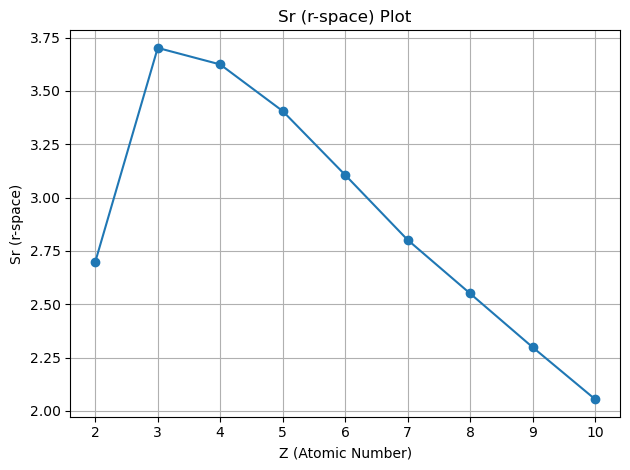

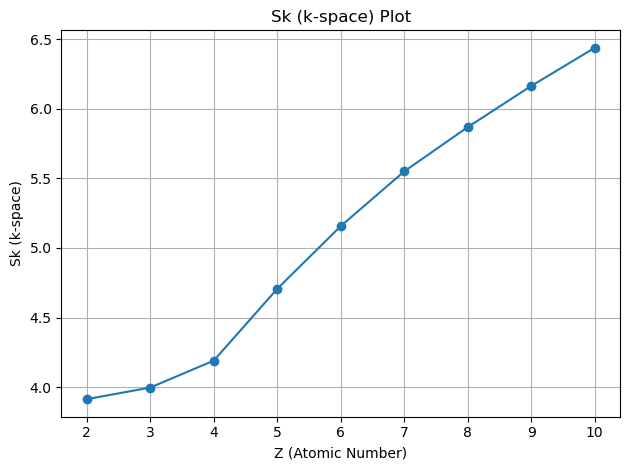

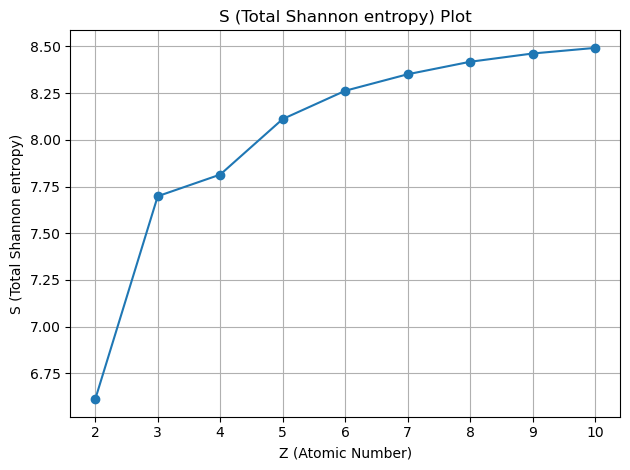

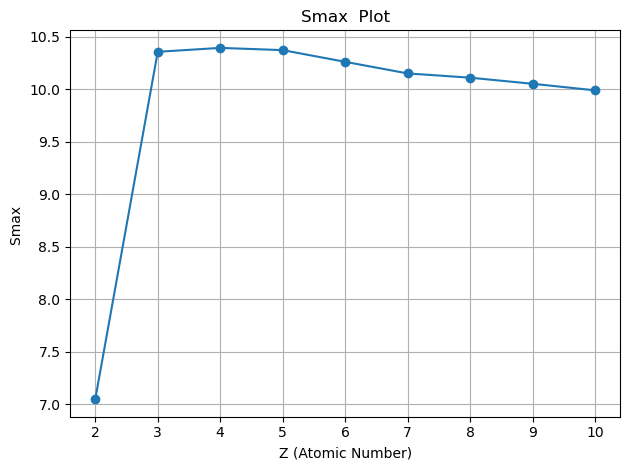

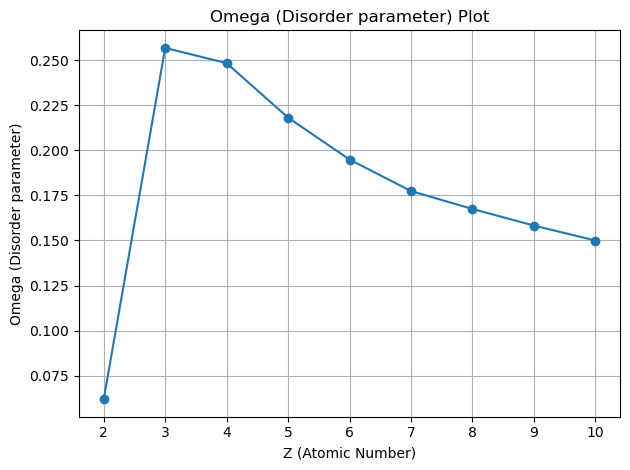

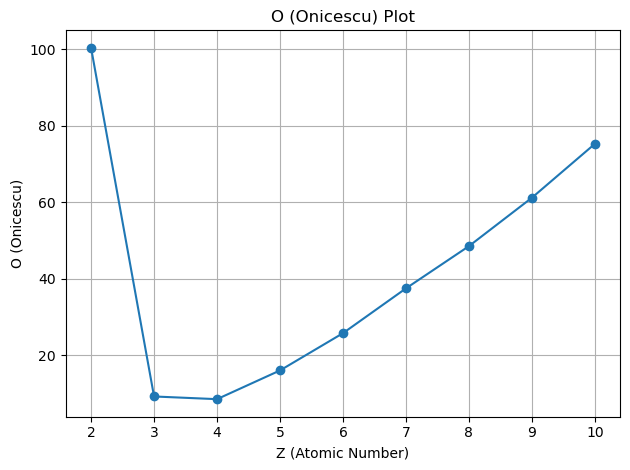

In [ ]:
import matplotlib.pyplot as plt


def plot_quantity(y_col, ylabel):    #function for plots takes as inputs the quantity we want to plot on y axis ,x is always Z
    plt.plot(final_df['Z'], final_df[y_col], marker='o', linestyle='-', color='tab:blue')
    plt.title(f'{ylabel} Plot')
    plt.xlabel('Z (Atomic Number)')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_quantity('Sr', 'Sr (r-space)')
plot_quantity('Sk', 'Sk (k-space)')
plot_quantity('S', 'S (Total Shannon entropy)')
plot_quantity('Smax', 'Smax ')
plot_quantity('Omega', 'Omega (Disorder parameter)')
plot_quantity('O', 'O (Onicescu)')


## Regression 
#### Regression on *"information entropy, information distances, and complexity in atoms"* Book data in order to confirm the exponential relation of Z with S.
#### We want a relation like $$ Z\sim e^S $$
#### So the proper form will be $$ Z=ae^{bS} \\ \Rightarrow lnZ=lna+bS $$
#### The only thing we have to do is to convert our Z-S data to lnZ-S and perform linear regression

In [ ]:
from scipy.stats import linregress
reg_dat = pd.read_csv('regress_data.csv')
Z=reg_dat['Z']
Z_ = np.log(reg_dat['Z'])#we convert the column Z to lnZ 
S = reg_dat['S']

In [ ]:
b, lna, r_value, p_value, std_err = linregress(S, Z_)
print(f"Regression Results:")
print(f"Equation: lnZ = {lna:.4f} + {b:.4f}·ln(Z)")
print(f"R-squared: {r_value**2:.6f}")
print(f"Standard error: {std_err:.6f}")
print(f"p-value: {p_value:.6e}")

Regression Results:
Equation: lnZ = -5.9531 + 0.9455·ln(Z)
R-squared: 0.989463
Standard error: 0.013531
p-value: 4.314591e-53


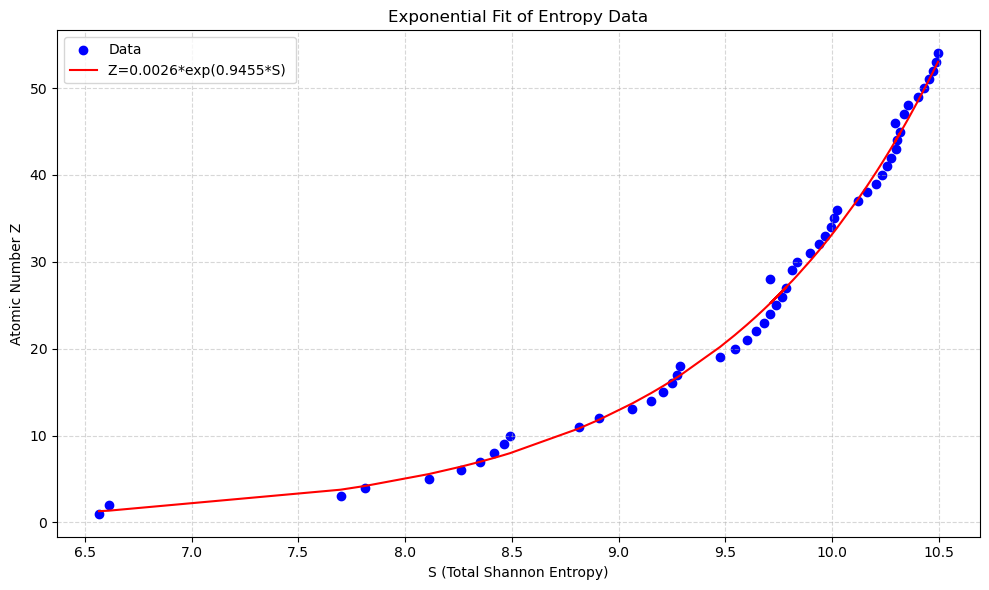

In [ ]:
#using the values from the regression we can plot the exponential function as we defined it in the markdown section
#before. We found lna as well as b. So we can find a as exp(lna) and simply construct the function. 


plt.figure(figsize=(10, 6))
plt.scatter(S, Z, color='blue', label='Data')
plt.plot(S, np.exp(lna)*np.exp(b*S), color='red', 
         label=f'Z={np.exp(lna):.4f}*exp({b:.4f}*S) ')
plt.xlabel('S (Total Shannon Entropy)')
plt.ylabel('Atomic Number Z')
plt.title('Exponential Fit of Entropy Data')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()

